In [29]:
%matplotlib inline
from momma_dragonn.data_loaders.hdf5_data_loader import MultimodalAtOnceDataLoader
data_loader = MultimodalAtOnceDataLoader(path_to_hdf5="valid_data.hdf5",
                                         bundle_x_and_y_in_generator=False,
                                         strip_enclosing_dictionary=True)
data = data_loader.get_data()

('Input modes', [u'sequence'])
('Output modes', [u'output'])
('num_to_load_for_eval is ', None, 'but num_items is', 14240, '- fixing')


In [30]:

model_load_configs = [
    {'weights': "model_files/record_99_model_0UAqF_modelWeights.h5",
     'json': "model_files/record_99_model_0UAqF_modelJson.json",
     'descriptor': "rc-t_nbf-16_ws-t_symws-f_ircws-t_str-20"},
    {'weights': "model_files/record_95_model_kbaIV_modelWeights.h5",
     'json': "model_files/record_95_model_kbaIV_modelJson.json",
     'descriptor': "rc-f_nbf-16_ws-f_str-20"}
]


In [43]:
for model_load_config in model_load_configs:
    weights = model_load_config['weights']
    json = model_load_config['json']
    descriptor = model_load_config['descriptor']
    keras_model = kc.load_keras_model(weights=weights,
                                      json=json)
    model_load_config['model'] = keras_model

In [ ]:
import deeplift.conversion.keras_conversion as kc
import matplotlib.pyplot as plt
nregions = 10000

X = np.array(data.X[:nregions])
Y = np.array(data.Y[:nregions])

In [41]:
sum((fwd_predictions > 0.5)*1 == Y)

array([9050])

rc-t_nbf-16_ws-t_symws-f_ircws-t_str-20
0.9213
0.9213
rc-f_nbf-16_ws-f_str-20
0.905
0.9054


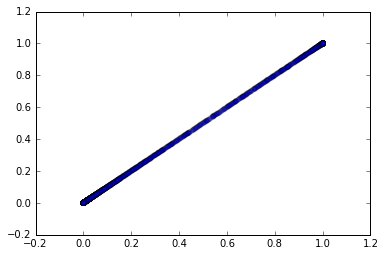

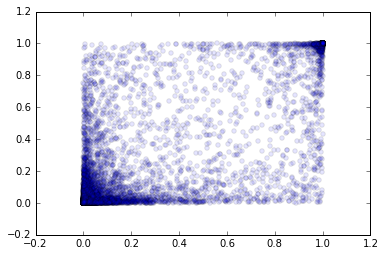

In [42]:
for model_load_config in model_load_configs:
    
    keras_model = model_load_config['model']
    fwd_predictions = keras_model.predict(X)
    rev_predictions = keras_model.predict(X[:,::-1,::-1])
    
    fwd_prediction_acc = np.sum((fwd_predictions > 0.5)*1 == Y)/float(nregions)
    rev_prediction_acc = np.sum((rev_predictions > 0.5)*1 == Y)/float(nregions)
    
    print(fwd_prediction_acc)
    print(rev_prediction_acc)
    
    plt.figure()
    plt.scatter(fwd_predictions, rev_predictions, alpha=0.1)

In [10]:
keras_model.layers

In [11]:
import theano
import keras.backend as K
layer9_out = theano.function([keras_model.input, K.learning_phase()],
                             keras_model.layers[9].output, allow_input_downcast=True)
layer10_out = theano.function([keras_model.input, K.learning_phase()],
                             keras_model.layers[10].output, allow_input_downcast=True)
layerm2_out = theano.function([keras_model.input, K.learning_phase()],
                             keras_model.layers[-2].output, allow_input_downcast=True)

In [12]:
import numpy as np
random_input = np.random.random((1,1000,4))

In [13]:
print(np.max(np.abs(layer9_out(random_input, False) - layer9_out(random_input[:, ::-1, ::-1], False)[:,::-1,::-1])))
print(layer10_out(random_input, False))
print(layer10_out(random_input[:,::-1,::-1], False))
print(layerm2_out(random_input, False))
print(layerm2_out(random_input[:,::-1,::-1], False))

2.6226e-06
[[ -2.51437783e-01   4.19698358e-01   8.48584414e-01  -5.57352304e-01
   -8.74572434e-04  -1.23056024e-03  -9.86010909e-01  -4.20085400e-01
    1.15228549e-01  -2.26033151e-01   8.87029395e-02   1.21177442e-01
   -3.24154906e-02   1.09678936e+00  -8.52027237e-02   4.34186101e-01
    3.25265288e-01  -5.27580976e-02   1.03787553e+00   1.42582193e-01
   -1.58223901e-02   3.08232903e-01  -1.06000900e-01   1.22726616e-02
   -2.55050123e-01  -6.84527159e-01   1.98173150e-01  -1.69384211e-01
   -1.59774750e-01   1.18553293e+00   1.51197106e-01  -2.89092243e-01]]
[[ -2.89092064e-01   1.51196986e-01   1.18553269e+00  -1.59774959e-01
   -1.69384241e-01   1.98173046e-01  -6.84527516e-01  -2.55050033e-01
    1.22724734e-02  -1.06000841e-01   3.08233023e-01  -1.58224478e-02
    1.42582163e-01   1.03787529e+00  -5.27581871e-02   3.25265676e-01
    4.34185922e-01  -8.52028951e-02   1.09678912e+00  -3.24154310e-02
    1.21177338e-01   8.87030512e-02  -2.26033270e-01   1.15228646e-01
   -4.2

In [23]:
import numpy as np
random_inp = np.random.random((10,1000,4))
print(keras_model.predict(random_inp))
print(keras_model.predict(random_inp[:, ::-1, ::-1]))
print(keras_model.predict(random_inp) - keras_model.predict(random_inp[:, ::-1, ::-1]))

[[ 0.07186917]
 [ 0.07434497]
 [ 0.12864782]
 [ 0.18770845]
 [ 0.04313384]
 [ 0.0209079 ]
 [ 0.02083969]
 [ 0.04040418]
 [ 0.03760781]
 [ 0.01761588]]
[[ 0.21423988]
 [ 0.05645425]
 [ 0.18132485]
 [ 0.07592847]
 [ 0.05251423]
 [ 0.05046884]
 [ 0.11245374]
 [ 0.02317481]
 [ 0.06928993]
 [ 0.04388957]]
[[-0.1423707 ]
 [ 0.01789072]
 [-0.05267704]
 [ 0.11177998]
 [-0.00938039]
 [-0.02956094]
 [-0.09161405]
 [ 0.01722937]
 [-0.03168212]
 [-0.0262737 ]]


In [22]:
print(descriptor)

rc-f_nbf-16_ws-f_str-20


In [9]:
#compute grad*input importance scores
import theano
from keras import backend as K
import numpy as np
score_func = theano.function([keras_model.input, K.learning_phase()],
                             (theano.grad(K.sum(keras_model.layers[-2].output[:,0],axis=0), keras_model.input)*
                              (keras_model.input - np.array([0.25, 0.25, 0.25, 0.25]).reshape([1,1,4]))),
                             allow_input_downcast=True)

In [11]:
fwd_scores = score_func(random_inp, False)

In [12]:
rev_scores = score_func(random_inp[:,::-1,::-1], False)

In [13]:
fwd_scores

array([[[  2.88720687e-05,   2.10542168e-06,  -3.05712719e-07,
           5.01426661e-06],
        [  6.44317652e-06,  -6.10106716e-06,   3.29393166e-05,
          -5.93701917e-06],
        [ -1.19300901e-05,   6.60085608e-05,  -3.63180555e-05,
          -3.47935793e-05],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          -0.00000000e+00],
        [ -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
          -0.00000000e+00]],

       [[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          -0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [ -9.30333819e-06,  -2.39654940e-05,  -3.66509386e-05,
           8.79684209e-06],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+0

In [14]:
rev_scores

array([[[ -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
          -0.00000000e+00],
        [ -1.49720193e-06,  -1.38762531e-06,   4.74566969e-06,
           1.83765845e-05],
        ..., 
        [ -2.30729281e-05,  -1.64095363e-04,   2.85617817e-04,
           7.44929357e-05],
        [  2.42459380e-05,   4.88165322e-05,  -8.79188661e-06,
          -1.63304653e-04],
        [  2.78936315e-06,   2.37722854e-06,  -2.99817116e-05,
          -1.83410632e-04]],

       [[  0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        ..., 
        [  4.09363629e-05,  -2.10790250e-05,  -8.65714357e-05,
          -5.59211855e-05],
        [  3.92407456e-06,  -5.50303633e-05,   8.22958304e-0